# The underflow problem of HMMs

There is an computational issue with the use of the EM algorithm for training HMMs, and this is called the underflow problem.
The issue has to do with the fact that, in the recursive algorithms, we are repeatedly multiplying small numbers by themselves many times. Think of the forward algorithm: if $\alpha <1$, the fact that $\alpha(t)$ is computed by multiplying $\alpha(t-1)$ recursively implies that a long sequence (of order hundred elements) will eventually produce an outcome of $0$.

## Viterbi algorithm

Viterbi is easy because it only involves multiplications. To solve the underflow problem in this case it is therefore enough to consider the $\log$ of the different quantities instead of the quntities themselves, as $$ \log(AB) = \log(A) + \log(B)\,,$$ which solves the underlfow problem.

## Scaling for Forward algorithm

Contrary to Viterbi, the forward, backward and also training algorithms involve multiplications but also sums, and therefore taking the $\log$ is not of any use.

The useful concept here involves **scaling**. To that end, we include a *scale factor* $$c(t),\ t=1,...\,.T$$ Now, the forward algorithm can be rewritten as

$$ \alpha'(1, i) = \pi_i B(j, x(1)) = \alpha(t, i) $$
$$ c(t) = \sum_{i=1}^M \alpha'(t,i)$$
$$\hat{\alpha}(t,i) = \frac{\alpha'(t, i)}{c(t)}$$

In particular $\hat{\alpha}(1,i) = \pi_i B(j, x(1))/c(1)$. Also, the induction step involves $\alpha'$ and $\hat{\alpha}$ now

$$ \alpha'(t, i) = \sum_{i=1}^M \hat{\alpha}(t-1, i) A(i,j)B(j,x(t))\,,$$

The probability of a sequence now becomes $$p(x_1,...,x_T) = \prod_{t=1}^T c(t)\,.$$ Now we have accomplished the desire expression of the probability **solely as a product**, not as a sum or combinations of sumas and products. Therefore, to avoid the underlfow problem, it is now as easy as taking the $\log$.

### Scaling for Backward algorithm

For the backward algorithm ($\beta$ update) it is not necessary to compute a new scale factor. We use the previous one $c(t)$.

The initialization step is still $$\hat{\beta}(T,i)=1\,.$$

The induction step involves the scaling $$ \hat{\beta}(t,i) = \frac{\sum_{j=1}^N A(i,j)B(j, x(t+1)\hat{\beta}(t+1, j))}{c(t+1)}$$

## Important identities

These will be used when recasting the update equations in terms of hatted variables.

$$ \left(\prod_{\tau=1}^T c(\tau)\right)\hat{\alpha}(t,i) = \alpha(t,i)\,,$$
$$ \hat{\alpha}(t,i)\hat{\beta}(t,i) p(x) = \alpha(t,i)\beta(t,i) \,,$$
$$ \alpha(t,i)\beta(t+1,j) = \frac{\hat{\alpha}(t,i)\hat{\beta}(t+1,j) p(x)}{c(t+1)}$$

## Update equations of the EM algorithm with scaling

$$ \pi_i = \frac{1}{N} \sum_{n=1}^N \hat{\alpha}_n(1,i)\hat{\beta}_n(1,i)$$
$$ A(i,j) = \frac{\sum_{n=1}^N \sum_{t=1}^{T_n-1} \frac{\hat{\alpha}_n(t,i)\hat{\beta}_n(t+1,j)}{c(t+1)} A(i,j) B(j, x_n(t+1))}{\sum_{n=1}^N \sum_{t=1}^{T_n-1} \hat{\alpha}_n(t,i)\hat{\beta}_n(t,i)}$$
$$ B(j,k) = \frac{\sum_{n=1}^N \sum_{t=1}^{T_n} \hat{\alpha}_n(t,j)\hat{\beta}_n(t,j) \text{  if  } x_n(t)=k \text{  else  } 0}{\sum_{n=1}^N \sum_{t=1}^{T_n} \hat{\alpha}_n(t,j)\hat{\beta}_n(t,j)}$$

The probability of observation is now implicitly included in the hatted variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Class HMM that fits the parameters and makes an inference

In [2]:
# create a valid random markov matrix
def random_normalized(dim1, dim2):
    """
    Creates a matrix of random numbers that are compatible with Markov
    (namely, they rows sum up to 1)
    """
    random_matrix = np.random.rand(dim1, dim2)
    #divide by sum over rows to make rows add up to 1 (Markov matrix)
    return random_matrix/random_matrix.sum(axis=1, keepdims=True)

In [3]:
# class HMM
class HMM:
    def __init__(self, num_hidden_states):
        self.M = num_hidden_states

    def fit(self, X: np.ndarray, max_iter: int = 30, verbose: bool=False):
        """
        Parameters:
            max_iter: maximum number of EM iterations to allow
            X: stores a set of observed sequences as rows.
        """
        # include seed for reproducibility
        np.random.seed(123)

        # vocabulary size (classes from 0 to V-1)
        # (number of x states = K is the maximum number 
        # of states in the training set found for a sequence)
        vocab_size = max(max(x) for x in X) + 1 
        num_sequences = len(X)

        # initialize pi, A and B
        self.pi = np.ones(self.M)/self.M # uniform distirbution for pi
        self.A = random_normalized(self.M, self.M)
        self.B = random_normalized(self.M, vocab_size)
        # store cost
        costs = list()
        for it in range(max_iter):
            #if it % 10 == 0:
            #    print('it:', it)
            alphas = list()
            betas = list()
            P = np.zeros(num_sequences) # probabilities
            # loop through observations
            for n in range(num_sequences):
                x = X[n] # n-th sequence
                T = len(x) # T_n

                #### Compute alpha[t]: forward algorithm
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]]
                for t in range(1, T):
                    # * is the element by element multiplication
                    alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                P[n] = alpha[-1].sum() # probability of a sequence
                alphas.append(alpha)

                #### Compute beta[t]: backward algorithm
                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T-2,-1,-1): # go backwards
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                betas.append(beta)

            #compute cost
            cost = np.sum(np.log(P))
            costs.append(cost)

            #### Reestimate pi, A and B
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences

            denominator_1 = np.zeros((self.M,1))
            denominator_2 = np.zeros((self.M,1))
            a_num = 0
            b_num = 0
            for n in range(num_sequences):
                x = X[n] # sequence
                T = len(x) # T_n 

                denominator_1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T/P[n]
                denominator_2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T/P[n]

                # nth update for A numerator
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i]*self.A[i,j]*self.B[j,x[t+1]] * betas[n][t+1,j]
                a_num += a_num_n/P[n]

                # nth update for B numerator
                b_num_n = np.zeros((self.M, vocab_size))
                for i in range(self.M):
                    for j in range(vocab_size):
                        for t in range(T):
                            if x[t] == j:
                                b_num_n[i,j] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n/P[n]

            # update A and B
            self.A = a_num/denominator_1
            self.B = b_num/denominator_2

            #self.alphas = alphas
            #self.betas = betas
            ## print & plot final estimates/costs
            if verbose:
                print('ITERATION:', it)
                print("A:", self.A)
                print('check A:', self.A.sum(axis=1))
                print("B:", self.B)
                print('check B:', self.B.sum(axis=1))
                print("pi:", self.pi)
                print('check pi:', self.pi.sum())
        self.alphas = alphas
        self.betas = betas

        # plot costs
        #plt.plot(costs)
        #plt.show()

    def likelihood(self, x):
        '''
        Computes the probability (likelihood) of a sequence
        by means of the forwards algorithm
        '''
        T = len(x) # T_n

        #### Compute alpha[t]: forward algorithm
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        for t in range(1, T):
            # * is the element by element multiplication
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
        return alpha[-1].sum()

    def likelihood_multi(self, X):
        '''
        Computes the probability (likelihood) for all the
        observations (sequences)
        '''
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        '''
        Computes the log likelihood of all the observations
        '''
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        '''
        Computes the most probable set of hidden states given 
        observation sequence x using the Viterbi algorithm
        '''
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi * self.B[:, x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j])*self.B[j, x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        ### Backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2,-1,-1):
            states[t] = psi[t+1, states[t+1]]

        return states

Train the HMM in a dataset of sequences of coin flips with heads (`H`) or tails (`T`) generated with the following parameters:

$$
\pi = (0.5,0.5).T\\
A = \begin{pmatrix}
0.1 & 0.9 \\
0.8 & 0.2 
\end{pmatrix}\\

B = \begin{pmatrix}
0.6 & 0.4\\
0.3 & 0.7
\end{pmatrix}
$$

The file is called `coin_data.txt` and can be found in 

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/hmm_class/coin_data.txt

In [4]:
def fit_coin():
    '''
    Create training set from coin_data.txt file
    and fit a HMM with it
    '''
    X = list()
    for line in open('coin_data.txt'):
        x = [1 if elm == 'H' else 0 for elm in line.rstrip()]
        X.append(x)

    hmm = HMM(2)
    hmm.fit(X,max_iter=100)
    L = hmm.log_likelihood_multi(X).sum()

    print("log likelihood after fitting:", L)
    
    # set HMM to the actual values that generated the series
    # of coin flips
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    L = hmm.log_likelihood_multi(X).sum()
    print("log likelihood of real generating model:", L)

    # try Viterbi on training set
    print("best state sequence for ", X[0])
    print(hmm.get_state_sequence(X[0]))

initial values: [0.5 0.5] [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]] [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it: 0
it: 10


/tmp/ipykernel_1644/389656226.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


it: 20
it: 30
it: 40
it: 50
it: 60
it: 70
it: 80
it: 90
ITERATION: 99
A: [[0.70371831 0.29628169]
 [0.28697428 0.71302572]]
check A: [1. 1.]
B: [[0.54110179 0.45889821]
 [0.54024348 0.45975652]]
check B: [1. 1.]
pi: [0.51003807 0.48996193]
check pi: 1.0000000000000002


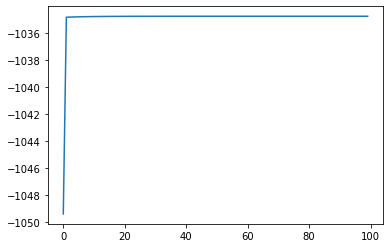

log likelihood after fitting: -1034.7539242965554
log likelihood of real generating model: -1059.7229160265022
best state sequence for  [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [86]:
fit_coin()

The problem with the above algorithms is *underflow*: after all, $\alpha$ and $\beta$ are small numbers ($<1$) and hence, for long sequences, the training algorithm will lead to zero for $\alpha$ really soon, meaning that all multiplications will be zero from that point on. To solve this issue, we will do the following:

- For the Viterbi algorithm we will use logs, since it only involve multiplications. Hence, we turn the multiplications into sums and avoid the underflow problem.

- For the Baum-Welch algorithm, we will use scaling. For this, we will use a scale factor $c_t\,, t=1,...,T$

## Tensorization

Trying to run the forward and backward algorithms in general for an arbitrary sequence of length 30 (such as the one here) leads to an out-of-memory situation. 
We will therefore substitute the value of the sequence at each timestep.

In [5]:
import numpy as np
from typing import Union, Optional, List

In [6]:
# create a valid random markov matrix
def random_normalized(dim1, dim2):
    """
    Creates a matrix of random numbers that are compatible with Markov
    (namely, they rows sum up to 1)
    """
    random_matrix = np.random.rand(dim1, dim2)
    #divide by sum over rows to make rows add up to 1 (Markov matrix)
    return random_matrix/random_matrix.sum(axis=1, keepdims=True)

def load_data(data_path='./coin_data.txt'):
    X = list()
    for line in open(data_path):
        x = [1 if elm == 'H' else 0 for elm in line.rstrip()]
        X.append(x)
    return np.array(X)

def generate_initial_parameters(vocab_size,
                                num_hidden_states,
                                random_seed=True):
    if random_seed:
        np.random.seed(123)

    # initialize pi, A and B
    pi = (np.ones(num_hidden_states)/num_hidden_states).reshape(num_hidden_states,1) # uniform distirbution for pi
    A = random_normalized(num_hidden_states,num_hidden_states)
    B = random_normalized(num_hidden_states, vocab_size)

    return pi, A, B

In [7]:
X_data = load_data()
print(X_data.shape) # 50 samples of 30 timesteps each
VOCAB_SIZE = max(max(x) for x in X_data) + 1 # 2 different observable states
NUM_SEQS, SEQ_LENGTH = X_data.shape
M_ = 2 # assume 2-dim hidden space

(50, 30)


### Forward algotihm for fixed input sequence

Note for example that $$ \alpha(t=1, j) = \pi_j B(j, x_1)\,,$$ where $x_1$ is just the observation associated to the first timestep. We will substitute explicitly this observation. Now, our dataset does not contain only one observation, but $N = 50$ of them. To vectorize everything, we will substitute the $N$ samples of $x_1$ observed.

This logic will be applied to the recursive algorithm as well.

In [8]:
def alpha_initial(input_sequences: np.ndarray, 
                    pi: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray]) -> np.ndarray:
    '''
    Computes the value of alpha associated to initial time t=1
    
    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        pi: Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states

    Return
        np.ndarray: initial value of alpha (namely, alpha_1)
    '''
    assert np.isclose(np.sum(pi), 1), "the sum of probabilities of initial latent states must add up to 1"
    assert (np.isclose(B.sum(axis=1), 1)).all(), "the total probability of a given observed state must be 1"
    # element-wise product with B evaluated on x(t=1) for all the rows (all the samples) at once
    # alpha_initial will end up having dimension M x N, where N is the total number of samples
    return np.multiply(pi, B[:,X_data[:,0]])

def beta_initial(A_dim: int, num_sequences: int) -> np.ndarray:
    '''
    Computes the value of beta associated to initial time t=T

    Parameters
        A_dim: int
            dimension of matrix A (namely, M in the above notation)

    Return
        np.ndarray: initial value of beta (namely, beta_1)
    '''
    return np.ones(shape=(A_dim, num_sequences)) # column vector of ones (one component per each z-state)


def forward_algo_input_fixed(
                    input_sequences: np.ndarray, 
                    A: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray], 
                    alpha_ini: np.ndarray
                    ) -> List[np.ndarray]:

    ''' 
    This is the forward algorithm as implemented in notebook forward_algo.ipynb
    but with the input sequences evaluated whenever possible to make the problem
    computationally light

    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        A:  Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states
        alpha_ini: np,ndarray
            The value of alpha(t=1, z_1)
    Return
        List[np.ndarray]: list of alphas of the form 
        [alpha(t=1, z_1),..., alpha(t=T-1, z_{T-1}), alpha(t=T, z_T)]
    '''
    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    assert isinstance(sequence_length, int), 'the length of the sequence must be an integer number'
    assert alpha_ini.shape[0] == A.shape[0], 'the length of the first axis of alpha_ini must be the rows of A'

    alphas_list = [alpha_ini] 
    for t_ in range(1,sequence_length):
        # np.einsum('ij,il->jl', A, alphas_list[t_-1]) gives the first part of the algorithm
        # factor1_jt = sum_i A_ij alpha(i,t) -> shape M x N
        # The second part of the formula np.multiply(B[:, input_sequences[:,t_]], factor1)
        # gives B(j, x_t) * factor1_jt
        alphas_list.append(np.multiply(B[:, input_sequences[:,t_]], 
                                        np.einsum('ij,il->jl', A, alphas_list[t_-1])))
    #alpha list has shape T x M x N
    return np.array(alphas_list)

def backward_algo_input_fixed(input_sequences: np.ndarray, 
                    A: Union[List, np.ndarray], 
                    B: Union[List, np.ndarray], 
                    beta_ini: np.ndarray
                    ) -> List[np.ndarray]:

    '''
    Computes a set of alphas following the (recursive) forward algorithm

    Parameters
        input_sequences: np.ndarray
            Input set of sequences, i.e. the training data
        A:  Union[List, np.ndarray]
            Initial vector of probabilities (i.e. p(z_1)) for each possible state of z_1
        B:  Union[List, np.ndarray]
            time-independent matrix of transition probabiltiies p(x_t|z_t) for each x- and z-states
        alpha_ini: np,ndarray
            The value of alpha(t=1, z_1)
    Return
        List[np.ndarray]: list of betas of the form 
        [beta(t=1, z_1), ..., beta(t=T-1, z_{T-1}), beta(t=T, z_T)]
    '''
    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    assert isinstance(sequence_length, int), 'the length of the sequence must be an integer number'
    assert beta_ini.shape[0] == A.shape[0], 'the length of the first axis of beta_ini must be the rows of A'

    # initialize betas list
    betas_list = [0]*sequence_length
    betas_list[-1] = beta_ini #beta_ini will be a M x N matrix of 1s
    for t_ in reversed(range(1,sequence_length)):
        # note that we don't use t+1 when indexing beta because 
        # python starts counting indexes from 0: reversed(range(0,sequence_length))
        # goes from sequence_length-1 to 0. The last index of betas_list
        # is also sequence_length-1
        exps1 = np.einsum('ij,js,jl->isl', A, B[:, input_sequences[:,t_]], betas_list[t_])
        # force (column of B) = (column of betas_list[t_]) = x_{t+1}  
        # i.e pick diagonal for first and last indices: s = l above, without summing over s!
        betas_list[t_-1] = np.diagonal(exps1, axis1=len(exps1.shape)-2, axis2=len(exps1.shape)-1)
        # note that index associated to z is first index of beta
        # (this is so also for beta_ini)
    return np.array(betas_list)

def probability_fixed_input_sequence(alpha: np.ndarray):
    '''
    Computes the probability of a fixed sequence of x states given an alpha 
    (this alpha is suppossed to correspond to alpha(t=T, z_T))

    Parameters:
        alpha: np.ndarray
            A tensor with dimensions (M, K, K,...,K)
    Returns:
        np.ndarray:
            A tensor with dimension (K, K,...,K)
    '''
    # sum alpha along the first direction (that would correspond to z_T)
    # returns probability for arbitrary set of x
    # (note the ordering: ijk... will correspond to x_T, x_{T-1}, x_{T-2},...)
    #return alpha.sum(axis=0)
    return np.einsum('i...->...', alpha)

In [9]:
pi_, A_, B_ = generate_initial_parameters(vocab_size=VOCAB_SIZE, num_hidden_states=M_)

**Example: Forward algorithm**

For a given sequence (given row) 

$$B(i,x_2) \rightarrow M \times 1$$
$$ \alpha(t=1,i) \rightarrow M \times 1$$
$$ A(j,i) \rightarrow M \times M$$
Recall that:
$$\alpha(t+1, i) = B(i, x_{t+1}) \sum_j^M A(j,i) \alpha(t, j)$$

In [14]:
alpha_ini = alpha_initial(X_data, pi_, B_)

In [8]:
# Example: 
# third sequence (n=3) only for z=2 (i.e. alpha(t=2, z=2))
assd=0
for i in range(2):
    assd += A_[i,1]*alpha_ini[i,2] #z, t and n start from 0!

B_[1, X_data[2,1]]*assd

0.17681246697497588

In [15]:
# compute the full list of alphas for all N
alpha_list = forward_algo_input_fixed(X_data, A_, B_, alpha_ini)
alpha_list[1][1,2] #alpha for t=2, z=2 and n=3

0.17681246697497588

In [10]:
assert B_[1, X_data[2,1]]*assd == alpha_list[1][1,2] #alpha for t=2, z=2 and n=3

In [11]:
assert (probability_fixed_input_sequence(alpha_list[-1]) > 0).all()
assert (probability_fixed_input_sequence(alpha_list[-1]) < 1).all()

In [16]:
prob = probability_fixed_input_sequence(alpha_list[-1])

**Example: Backward algorithm**

For a given sequence 

$$B(i,x_{29}) \rightarrow M \times 1$$
$$ \beta(t=T,i) \rightarrow M \times 1$$
$$ A(j,i) \rightarrow M \times M$$
Recall that:
$$\beta(t, i) = \sum_j^M A(i,j)B(j, x_{t+1})\beta(t+1, j)$$

In [17]:
beta_ini = beta_initial(M_, NUM_SEQS)
beta_ini.shape

(2, 50)

In [14]:
# z=2, n=3, t=29 from  beta_ini (recall that beta_ini corresponds to t=T=30)
basse = 0
for j in range(M_):
    basse += A_[1,j]*B_[j, X_data[2,-1]]*beta_ini[j, 2]
basse

0.6007470210010455

In [18]:
beta_list = backward_algo_input_fixed(X_data, A_, B_, beta_ini)
beta_list[-2][1,2] # dimension T x M x N

0.6007470210010455

In [16]:
assert basse == beta_list[-2][1,2]

## Update $\pi$ 


In [19]:
def update_pi(alpha_list: np.ndarray, beta_list: np.ndarray) -> np.ndarray:
    '''
    Formula to update \pi according to Baum Welch

    Three equivalent ways

    Method 1: 
        np.multiply(beta_list[0]/prob,alpha_list[0]).mean(axis=1)
        
    Method 2:
        llo = 0
        for n in range(NUM_SEQS):
            llo += beta_list[0][:,n] * alpha_list[0][:, n]/prob[n]
        llo/NUM_SEQS

    Method 3:
        ss = np.diag(np.einsum('ij,lj', beta_list[0]/prob, alpha_list[0]))
        ss/NUM_SEQS

    Parameters:
        alpha_list: np.ndarray
            A tensor with dimensions (T, M, N)
        beta_list: np.ndarray
            A tensor with dimensions (T, M, N)
    Returns:
        np.ndarray:
            A tensor with dimension (M, 1)
    '''
    prob = probability_fixed_input_sequence(alpha_list[-1])
    return (np.multiply(beta_list[0]/prob, alpha_list[0]).mean(axis=1)).reshape(beta_list.shape[1],1)

In [20]:
hmm = HMM(2)
hmm.pi = pi_
hmm.A = A_
hmm.B = B_
hmm.fit(X_data, max_iter=1)

/tmp/ipykernel_241/3611249952.py:59: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


## Update A

$$ 

A_{ij} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)A_{ij}B_{j, x_n(t+1)}\beta_n(t+1,j)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)\beta_n(t,i)}\,,\\

$$

In [21]:
def update_A(input_sequences: np.ndarray, 
            alpha_list: np.ndarray, 
            beta_list: np.ndarray,
            A_old: np.ndarray,
            B_old: np.ndarray) -> np.ndarray:

    prob = probability_fixed_input_sequence(alpha_list[-1])

    # be careful with reshape! It does not move axis directly!
    # use np.moveaxis to turn shape (a,b,c) into (b,c,a), for example
    # turn dimension of B_old[:, input_sequences[:,1:]] into shape of beta_list[1:,:,:]
    interm_ = np.moveaxis(B_old[:, input_sequences[:,1:]],-1,0)
    # note that in the formula B(j,x_{n,t+1}) involves th eexact same indices as
    # beta_n(t,j), so we can multiply element by element
    # also divide by P_n straight away (see formula)
    beta_B = (interm_*beta_list[1:,:,:]/prob)

    # We use the X[1:,:,:] in the indices to denote that what enters is t+1

    # A_{ij} does not involve t, n, so we move it away from sums
    # sum in t goes from t=1 to T-1. This involves using alpha_list[:-1,:,:]
    # (t+1) goes from 1 to T, that explain the indices of B and beta above
    # alpha coes with index z=i and beta_B with z=j, that is why those indices
    # remain free to match with A_old{ij}
    numerator = A_old*np.einsum('ijk,irk->jr', alpha_list[:-1,:,:], beta_B) # dim MxM
    '''
    Another way:
        numerator = np.einsum('ijk,lm,nki,irk->jlmnr', alpha_list[:-1,:,:], A_, B_[:, input_sequences[:,1:]], beta_list[1:,:,:]/prob)
        numerator = np.diagonal(numerator, axis1=0, axis2=1)
        numerator = np.diagonal(numerator, axis1=0, axis2=1)
        numerator = np.diagonal(numerator, axis1=0, axis2=len(numerator.shape)-1)
    '''
    denominator = np.diag(np.einsum('ikj,isj->ks', alpha_list[:-1,:,:], beta_list[:-1,:,:]/prob)) # dim M 

    # see formula: we want numerator[i,j]/denominator[i]
    #reshape denominator to acquire dimension Mx1
    return numerator/denominator.reshape(denominator.shape[0],1)

In [22]:
update_A(X_data, alpha_list, beta_list)

TypeError: update_A() missing 2 required positional arguments: 'A_old' and 'B_old'

## Update B

$$
B_{jk} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j) \mathbb{1}(x_n(t)=k)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j)}\,,
$$

In [23]:
def update_B(input_sequences: np.ndarray, 
            alpha_list: np.ndarray, 
            beta_list: np.ndarray) -> np.ndarray:

    prob = probability_fixed_input_sequence(alpha_list[-1])

    vocab_size = max(max(x) for x in input_sequences) + 1
    # define delta-type object, that is only 1 whenever k equals x_n(t)
    mask_u = list()
    for k_ in range(vocab_size):
        # place 1. if condition is fullfilled, 0. otherwise
        mask_u.append(np.where(input_sequences == k_, 1., 0.))
    mask_u = np.array(mask_u) # dim KxNxT

    # indices of alpha_list and beta_list coincide, so we can multiply elemen by element
    unmasked_num = (alpha_list*beta_list/prob)
    # mask numerator with mask_u
    numerator = np.einsum('ijk,lki->jl', unmasked_num, mask_u) # dim MxK
    #denominator is just the unmasked numerator summed over t and n
    denominator = np.einsum('ijk->j', unmasked_num) # dim M 

    # see formula: we want numerator[j,k]/denominator[j]
    #reshape denominator to acquire dimension Mx1
    return numerator/denominator.reshape(denominator.shape[0],1)

In [24]:
update_B(X_data, alpha_list, beta_list)

array([[0.56095853, 0.43904147],
       [0.52091592, 0.47908408]])

## Tensorized Viterbi

$$ \delta(t=1, j) = \pi(j) B(j,x_1)$$

$$ \delta(t, j) = \text{max}_{i\in \{1,...,M\}} \left[\delta(t-1,i) A(i,j)\right] B(j, x_t)\,, \hspace{1cm} j=1,...,M $$

$$p^* = \text{max}_{i\in \{1,...,M\}} \delta (t=T, j) $$

In [72]:
def viterbi(input_sequences: np.ndarray, 
            pi: np.ndarray,
            A: np.ndarray,
            B: np.ndarray) -> np.ndarray:
    ''''
    Apply a tensorized version of the Viterbi algorithm
    
    '''
    sequence_length = input_sequences.shape[1]
    A = np.array(A)
    B = np.array(B)
    pi = np.array(pi).reshape(B.shape[0], 1)

    # define initial delta
    delta_ini = np.multiply(pi, B[:, input_sequences[:, 0]]) # M x N

    deltas_list = [delta_ini]
    # initial psi = 0 with dim MxN
    psis_list = [np.zeros(shape=(B.shape[0], input_sequences.shape[0]))] 
    for t_ in range(1,sequence_length):
        # compute A(i,j)*delta(t-1, i) (no summation!) by first getting all indices
        # and then picking the appropriate diagonal (axis=0 (i) with axis=2 (k))
        extend_elmnt_prod = np.einsum('ij,kl->ijkl', A_, deltas_list[t_-1])
        elmnt_prod = np.diagonal(extend_elmnt_prod, axis1=0, axis2=2) # M(j) x N x M(i)
        # get maximum in the direction of i (axis=2)
        max_elmnt_prod = np.max(elmnt_prod, axis=2) # M(j) x N
        # multiply by B[:, input_sequences[:, t]] (also with dim = M x N)
        # and append
        deltas_list.append(np.multiply(max_elmnt_prod, 
                    B[:, input_sequences[:, t_]])) # element appended has dim= M x N
        # append psi[t,j]
        psis_list.append(np.argmax(elmnt_prod, axis=2)) # M(j) x N
    
    ### Backtracking algorithm
    optim_states = np.zeros_like(input_sequences) # N x T
    #[np.zeros(shape=(1,input_sequences.shape[0]))]*sequence_length
    #optim_states[-1] = np.argmax(deltas_list[-1], axis=0) # argmax(delta(T)) has dim = N
    optim_states[:,-1] = np.argmax(deltas_list[-1], axis=0) # argmax(delta(T)) has dim = N
    #return np.array(psis_list), optim_states
    # go barckards
    for t_ in reversed(range(1,sequence_length)):
        # preserve time direction
        # first compute general tensor with all indices
        # and then pick diagonal: so for example, for t_=29
        #you get np.array(psis_list)[29, optim_states[i,29], i] for i=0,...,N-1
        optim_states[:, t_-1] = np.diagonal(np.array(psis_list)[t_, 
                                                    optim_states[:, t_], :]) # diag of N x N matrix

    return np.array(deltas_list), np.array(psis_list), optim_states

## check

In [73]:
dlt, psps, opt_st = viterbi(X_data, pi_, A_, B_)

In [81]:
T = X_data.shape[1]
delta = np.zeros((T, 2))
psi = np.zeros((T, 2))
# for each n
for n_ in range(50):
    # compare version with for loops...
    delta[0] =pi_.reshape(2,) * B_[:, X_data[n_,0]]
    for t in range(1,T):
        for j in range(2):
            delta[t,j] = np.max(delta[t-1]*A_[:,j])*B_[j, X_data[n_,t]]
            psi[t,j] = np.argmax(delta[t-1]*A_[:,j])
    # ... with tensorized version
    ddt_ = np.array(dlt)[:,:,n_]
    pss_ = np.array(psps)[:,:,n_]
    
    if not np.isclose(delta, ddt_).all():
        print('DELTA DIFF', n_)
    if not np.isclose(psi, pss_).all():
        print('PSI DIFF', n_)

    ### Backtrack
    states = np.zeros(T, dtype=np.int32)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2,-1,-1):
        states[t] = psi[t+1, states[t+1]]

    if not np.isclose(states, opt_st[n_,:]).all():
        print('STATES DIFF', n_)

## Define tensorized HMM

In [115]:
class TensorizedHMM:

    def __init__(self, num_hidden_states):
        self.M = num_hidden_states
    @profile
    def fit(self, X: np.ndarray, max_iter: int = 30, verbose: bool = False):
        """
        Parameters:
            max_iter: maximum number of EM iterations to allow
            X: stores a set of observed sequences as rows.
        """

        # include seed for reproducibility
        np.random.seed(123)

        # vocabulary size (classes from 0 to V-1)
        # (number of x states = K is the maximum number 
        # of states in the training set found for a sequence)
        vocab_size = max(max(x) for x in X) + 1 
        num_sequences = len(X)

        # initialize pi, A and B
        self.pi, self.A, self.B = generate_initial_parameters(
                                                vocab_size=vocab_size, 
                                                num_hidden_states=self.M)
        # store cost
        costs = list()
        for it in range(max_iter):
            #if it % 10 == 0:
            #    print('it:', it)

            #### Compute alpha
            alpha_ini = alpha_initial(X, self.pi, self.B)
            # compute the full list of alphas for all N
            self.alpha_list = forward_algo_input_fixed(X, self.A, self.B, alpha_ini)

            #### compute beta
            beta_ini = beta_initial(self.M, num_sequences)
            self.beta_list = backward_algo_input_fixed(X, self.A, self.B, beta_ini)

            #### compute cost
            P = probability_fixed_input_sequence(self.alpha_list[-1])
            cost = np.sum(np.log(P))
            costs.append(cost)

            #### Reestimate pi, A and B
            self.pi = update_pi(self.alpha_list, self.beta_list)
            self.A = update_A(X, self.alpha_list, self.beta_list, self.A, self.B)
            self.B = update_B(X, self.alpha_list, self.beta_list)

            if verbose:
                ## print & plot final estimates/costs
                print('ITERATION:', it)
                print("A:", self.A)
                print('check A:', self.A.sum(axis=1))
                print("B:", self.B)
                print('check B:', self.B.sum(axis=1))
                print("pi:", self.pi)
                print('check pi:', self.pi.sum())

        
        # plot costs
        #plt.plot(costs)
        #plt.show()

    def likelihood(self, x):
        '''
        Computes the probability (likelihood) of a sequence
        by means of the forward algorithm
        '''
        
        alpha_ini = alpha_initial(x, self.pi, self.B)
        # compute the full list of alphas for all N
        self.alpha_list = forward_algo_input_fixed(x, self.A, self.B, alpha_ini)

        return probability_fixed_input_sequence(self.alpha_list[-1])

    def likelihood_multi(self, X):
        '''
        Computes the probability (likelihood) for all the
        observations (sequences)
        '''
        #return np.array([self.likelihood(x) for x in X])
        return self.likelihood(X)

    def log_likelihood_multi(self, X):
        '''
        Computes the log likelihood of all the observations
        '''
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        '''
        Computes the most probable set of hidden states given 
        observation sequence x using the Viterbi algorithm

        x can have dimension N x T
        '''
        return viterbi(x, self.pi, self.A, self.B)[2]

## Comparison and speed

In [116]:
import matplotlib.pyplot as plt
import time
import pickle
# the random state is fixed so that the initial state is identical.
thmm = TensorizedHMM(2)
hmm = HMM(2)

In [100]:
with open("./dict_tensor.pickle", 'rb') as ff:
    tensor_time_stats = pickle.load(ff)
with open("./dict_original.pickle", 'rb') as ff:
    basic_time_stats = pickle.load(ff)

In [101]:
tensor_time_stats = dict()
for m_iter in [10,30,50,100]:
    tensor_time_stats[m_iter] = list()
    for exp_ in range(500):
        #if exp_ % 10 == 0:
        #    print(exp_)
        start = time.time()
        thmm = TensorizedHMM(2)
        thmm.fit(X_data, max_iter=m_iter)
        tensor_time_stats[m_iter].append(time.time()-start)

In [102]:
basic_time_stats = dict()
for m_iter in [10,30,50,100]:
    basic_time_stats[m_iter] = list()
    for exp_ in range(500):
        #if exp_ % 10 == 0:
        #    print(exp_)
        start = time.time()
        hmm = HMM(2)
        hmm.fit(X_data, max_iter=m_iter)
        basic_time_stats[m_iter].append(time.time()-start)

/tmp/ipykernel_241/3611249952.py:59: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


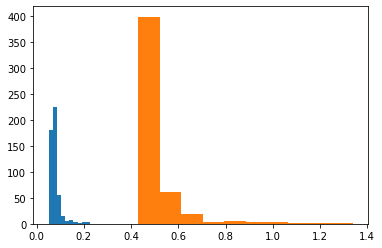

In [106]:
plt.hist(tensor_time_stats[30])
plt.hist(basic_time_stats[30])
plt.show()

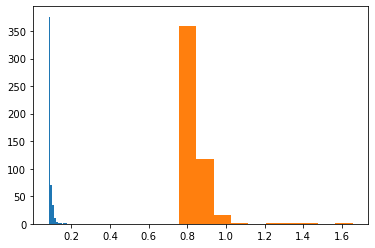

In [107]:
plt.hist(tensor_time_stats[50])
plt.hist(basic_time_stats[50])
plt.show()

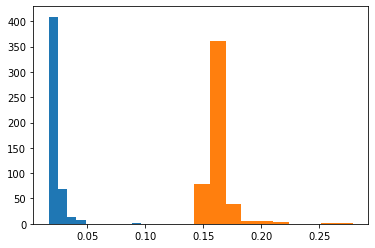

In [108]:
plt.hist(tensor_time_stats[10])
plt.hist(basic_time_stats[10])
plt.show()

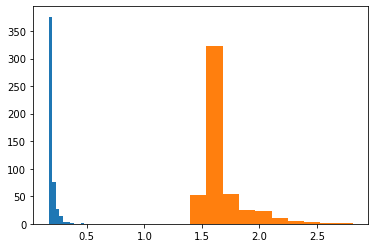

In [109]:
plt.hist(tensor_time_stats[100])
plt.hist(basic_time_stats[100])
plt.show()

In [110]:
print(np.max(tensor_time_stats[10]))
print(np.max(basic_time_stats[10]))

0.09674882888793945
0.2788271903991699


In [111]:
print(np.max(tensor_time_stats[100]))
print(np.max(basic_time_stats[100]))

0.47867298126220703
2.8119468688964844


In [112]:
print(np.max(tensor_time_stats[30]))
print(np.max(basic_time_stats[30]))

0.22649335861206055
1.3389456272125244


In [113]:
print(np.max(tensor_time_stats[50]))
print(np.max(basic_time_stats[50]))

0.17881441116333008
1.656498908996582


In [105]:
"""with open("./dict_tensor.pickle", 'wb') as ff:
    pickle.dump(tensor_time_stats, ff)
with open("./dict_original.pickle", 'wb') as ff:
    pickle.dump(basic_time_stats, ff)"""

## Profiling

In [114]:
import cProfile, pstats, io
from pstats import SortKey

def profile(fnc):
    '''A decorator that uses CProfile for profiling a function fnc'''
    
    def inner(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = SortKey.CUMULATIVE
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval
    
    return inner